# Test and Trace resampling

In this notebook, we relax the random sampling assumption by introducing two additional model parameters:

- The testing rate for infected individuals
- The testing rate for non-infected individuals

To estimate these within our model, we slightly adapt our framework to incorporate a random survey that runs parallel to the Test and Trace scheme. This survey records individual attendances in the studied settings but does not record antigen test results. Thus, our model now is now fitted with data from the survey sample and data from the Test and Trace sample.

In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Parameters
P = 10
S = 325949 # Total population
NA = 4*(10 ** 4) # Number of surveys
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

t_i = np.random.beta(8, 2, 1)  # Prob(tested | infected)
t_not_i = np.random.beta(2, 20, 1)  # Prob(tested | not-infected)
true_gamma = np.array([t_i, t_not_i])

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], S)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], S)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, S)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Resampling using testing probabilites conditional on infected
tested = y*np.random.binomial(1, true_gamma[0], S) + (1-y)*np.random.binomial(1, true_gamma[1], S)
y = y[tested == 1]
if NA >= (S - y.shape[0]):
    X_survey = X[tested == 0].reset_index()
else:
    X_survey = X[tested == 0].reset_index().sample()
X = X[tested == 1].reset_index()

N = X.shape[0]
NA = X_survey.shape[0]

X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')]
X.info()
X_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      8192 non-null   int64
 1   O2      8192 non-null   int64
 2   O3      8192 non-null   int64
 3   O4      8192 non-null   int64
 4   O5      8192 non-null   int64
 5   O6      8192 non-null   int64
 6   O7      8192 non-null   int64
 7   O8      8192 non-null   int64
 8   O9      8192 non-null   int64
 9   O10     8192 non-null   int64
dtypes: int64(10)
memory usage: 640.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21808 entries, 0 to 21807
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      21808 non-null  int64
 1   O2      21808 non-null  int64
 2   O3      21808 non-null  int64
 3   O4      21808 non-null  int64
 4   O5      21808 non-null  int64
 5   O6      21808 non-null  int64
 6   O7      21808 non-null  int64
 7   O8 

In [5]:
# Stan model code
model_code = """
data {
  int<lower=0> N;                            // number of test observations
  int<lower=0> NA;                           // number of survey observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences of tested individuals
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=0, upper=1> survey[NA,P];        // activity occurrences of surveyed individuals
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
  real<lower=0, upper=1> gamma[2];           // testing rates, given infected status [Pr(T|I) , Pr(T|!I)]
}
transformed parameters {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  real log_gamma[2];
  real log1m_gamma[2];
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_gamma[i] = log(gamma[i]);
    log1m_gamma[i] = log1m(gamma[i]);
  }
  log1m_rho = log1m(rho);
}
model {
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  gamma ~ uniform(0,1);

  // Likelihood
  for (n in 1:NA) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma[1]), (s+log1m_gamma[2]));
  }
  
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += (log1m_exp(s)+log_gamma[1]);
    } 
    else {
      target += (s+log_gamma[2]);
    }
  }
}
""" 

In [6]:
# Build model
model_data = {'N': N, 'NA': NA, 'P': P, 'X': X.to_numpy(), 
                         'y': y.to_numpy(), 'survey': X_survey.to_numpy()}
posterior = stan.build(model_code, data=model_data, random_seed=1)

Building...
Found model in cache. Done.


In [ ]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

# Posterior sampling
start = time.time()
fit = posterior.sample(num_samples=nuts_samples, num_warmup=nuts_burnin, num_chains=nuts_chains)
print(f"{time.time() - start:.02f} seconds elapsed")

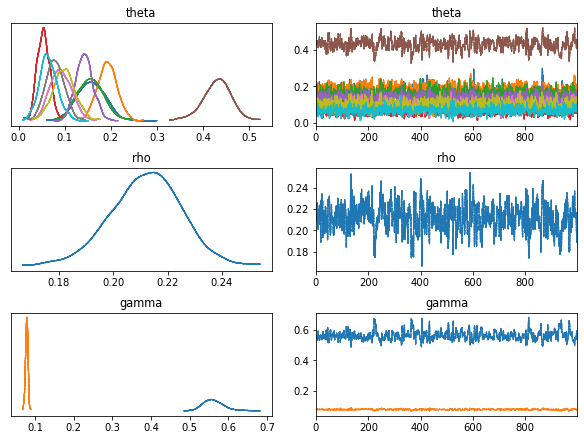

In [8]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [10]:
fit = fit.to_frame()
print("Inference on fitted model:")
fit.describe().T

Inference on fitted model:


,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,16000.0,-20712.932281,2.598842e+00,-20723.969652,-20714.480366,-20712.534149,-20711.104045,-20707.194581
accept_stat__,16000.0,0.944682,7.202814e-02,0.414255,0.925368,0.974298,0.992838,1.000000
stepsize__,16000.0,0.189168,2.867241e-14,0.189168,0.189168,0.189168,0.189168,0.189168
treedepth__,16000.0,4.148000,3.822370e-01,3.000000,4.000000,4.000000,4.000000,6.000000
n_leapfrog__,16000.0,21.704000,9.363219e+00,7.000000,15.000000,15.000000,31.000000,63.000000
divergent__,16000.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,16000.0,20719.458009,3.642398e+00,20710.759657,20716.821206,20719.005097,20721.718956,20732.645495
theta.1,16000.0,0.157600,3.166438e-02,0.060522,0.136150,0.157222,0.178964,0.299592
theta.2,16000.0,0.192438,2.095826e-02,0.134840,0.178355,0.192147,0.205867,0.270909


In [11]:
print('Ground truth:')
print('Setting-specific transmission rates: ', true_transmission_rate)
print('Base rate: ', base_rate)
print('Testing rates: ', true_gamma)

Ground truth:
Setting-specific transmission rates:  [0.11229016 0.21544007 0.1340044  0.03496042 0.14024028 0.38996209
 0.06151853 0.09666885 0.08617048 0.05264691]
Base rate:  [0.20607471]
Testing rates:  [[0.5876954 ]
 [0.07538611]]
